In [1]:
!jupyter nbconvert --to script Mdeep.ipynb
!jupyter nbconvert --to script Classic_Models.ipynb
!pip install shap
!pip install pydotplus

[NbConvertApp] WARNING | pattern 'Pre_Processing.ipynb' matched no files

This application is used to convert notebook files (*.ipynb) to various other


formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
    Equivalent to: [--ExecutePreprocessor.allow_errors=True]
--stdin
    rea

[NbConvertApp] Converting notebook Mdeep.ipynb to script
[NbConvertApp] Writing 9120 bytes to Mdeep.py
[NbConvertApp] Converting notebook Classic_Models.ipynb to script
[NbConvertApp] Writing 1143 bytes to Classic_Models.py


In [2]:
import numpy as np
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from Mdeep import train_test_mdeep, model_predict_mdeep
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from Classic_Models import Perceptron_Model, SVM_Model, Decision_Tree_Model, Random_Forest_Model
import shap
from sklearn import tree
import graphviz
import pydotplus
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, fbeta_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


ERROR: Could not find a version that satisfies the requirement TensorFlow==1.12.0
ERROR: No matching distribution found for TensorFlow==1.12.0
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:

def calculate_shap_values(model, x_train):
    explainer = shap.KernelExplainer(model, data=x_train)
    shap_values = explainer.shap_values(x_train)
    return shap_values

def drop_columns_with_high_zero_percentage(data, correlationTable, threshold):
    data = pd.read_csv('table_with_classe.csv', sep=';')
 
    zero_percentages = (data.drop('Classe', axis=1) == 0).mean()


    columns_to_drop = zero_percentages[zero_percentages > threshold].index


    data = data.drop(columns=columns_to_drop)
    print(data.shape)
    features_name = data.columns[1:]
    np.save("features_name.npy", features_name)
    correlationTable = correlationTable[["Unnamed: 0"] + list(features_name)]
    correlationTable.rename(columns={
       "Unnamed: 0": "Unnamed"
    }, inplace=True)
    correlationTable = correlationTable.loc[correlationTable['Unnamed'].isin(features_name)]
    correlationTable.drop('Unnamed', axis='columns', inplace=True)
    C = np.ones((correlationTable.shape[0], correlationTable.shape[1]))
    for i in range(correlationTable.shape[0]):
        for j in range(correlationTable.shape[1]):
            C[i][j] = float(correlationTable.values[i][j])
    np.save("./c.npy", C)

    return data

def extract_last_word(element):
  
    parts = element.split(';')
    last_word = parts[-1].strip()
    return last_word



def mapear_datasets(primeirodataset, segundodataset):
    df1 = primeirodataset.copy()
    df2 = segundodataset.copy()
    
    nomes_colunas = df1.columns[1:]
    mapper={}
    i=0
    
    for elemento_busca in nomes_colunas:
        indice_linha = df2.index[df2['#OTU ID'] == elemento_busca].tolist()

        
        if len(indice_linha) > 0:
            indice_linha = indice_linha[0]  
            valor_correspondente = df2.at[indice_linha, 'taxonomy']
            mapper[elemento_busca] = extract_last_word(valor_correspondente)
    

    df1.rename(columns=mapper, inplace=True)
    
    return df1

def plot_Confusion_Matrix(confusion_mat):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(confusion_mat, cmap='Blues')


    classes = np.unique(y_test)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")


    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, confusion_mat[i, j], ha="center", va="center", color="black")


    ax.set_title("Matriz de Confusão")
    ax.set_xlabel("Rótulos Previstos")
    ax.set_ylabel("Rótulos Reais")


    plt.show()



def plot_Confusion_Matrices(confusion_matrices_with_names):
    num_matrices = len(confusion_matrices_with_names)
    num_cols = 3 if num_matrices > 3 else num_matrices
    num_rows = (num_matrices + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

    if num_matrices == 0:
        plt.show()
        return

    for i, (name, confusion_mat) in enumerate(confusion_matrices_with_names):
        if confusion_mat is not None:
            ax = axs[i // num_cols, i % num_cols] if num_rows > 1 else axs[i % num_cols]
            im = ax.imshow(confusion_mat, cmap='Blues')

            classes = np.unique(y_test)
            class_labels = ['Saudável' if cls == 0 else 'Doente' for cls in classes]
            ax.set_xticks(classes)
            ax.set_yticks(classes)
            ax.set_xticklabels(class_labels)
            ax.set_yticklabels(class_labels)

            plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

            for i in range(len(classes)):
                for j in range(len(classes)):
                    text = ax.text(j, i, confusion_mat[i, j], ha="center", va="center", color="black")

            ax.set_title(f"{name}")
            ax.set_xlabel("Rótulos Previstos")
            ax.set_ylabel("Rótulos Reais")

    plt.tight_layout()
    plt.show()
    
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    return precision, recall, accuracy, f1, f2

In [4]:
torch.manual_seed(47)
np.random.seed(47)

In [5]:
data = pd.read_csv("./table_with_classe.csv", sep=";")
correlationTable = pd.read_csv('./correlationTable.csv', sep= ',')
ASV_code_names = pd.read_csv("./ASV_codes_names.csv", sep=",")

In [6]:
ASV_code_names.head()

,#OTU ID,taxonomy
0,e2043b51e45e03a5735429445e7f1cf6,d__Bacteria; p__Planctomycetota; c__Planctomyc...
1,30373337a62613615bbe5f8bad456cef,d__Bacteria
2,660a77e68e631466ce229e6f58551e85,d__Bacteria; p__Proteobacteria; c__Alphaproteo...
3,7101ce37043ece3c2fe4edbc6b328ce7,d__Bacteria; p__Proteobacteria; c__Alphaproteo...
4,d5ea2226f3f50d2619db6d102ab3aba8,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...


In [7]:
data.head()

,Classe,e2043b51e45e03a5735429445e7f1cf6,30373337a62613615bbe5f8bad456cef,660a77e68e631466ce229e6f58551e85,7101ce37043ece3c2fe4edbc6b328ce7,d5ea2226f3f50d2619db6d102ab3aba8,6cbf1db3e5dc7b0bea0a90c3451ebb2d,c6f21eded27928e174da264d712917a7,0dc44afca700fb9e5bf497d40c8e5f0b,a3849b44a3f3574cce58d0caacd0b9d7,...,5349acbd5acc509cdd69b59534b9e8c5,08d8cbe422ce6345ef631568d4bdf3e2,0dc17c7f061e619883ff5ca7ca9f507d,96d638c608474164eead13de2ee289ac,8bf2484e9fce15e2f46db427d5d5e408,eca5c08dff5c9c446e353a66e6912980,56402f4fa0a6ff39f78bb7b07f0611fd,4de78c5ada4c4eb10c4588b67c4e0d59,75d1ed4bad4e74f4f853ed71cb0d9482,bf56bba4182ef571c28b1144385b6301
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data["Classe"].value_counts()

1    63
0    47
Name: Classe, dtype: int64

In [9]:
data_for_classifiers = drop_columns_with_high_zero_percentage(data, correlationTable, threshold=0.5)

(110, 41)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
data_for_classifiers.head()

,Classe,281f3798d6ccc207a86d9dae71b3d08d,0a05c93d825708684ee698486d42119e,6406a8336a43d0dfaf0ed6417a4206dd,8ff90675ebf3c4d1b731d727d007ad2f,2fcc5160f3926f58ac09da7186b384ab,f5e95d6eea6263f1c5804ce65b1d203f,f567dc1eb18f77581e76b6756b7b11f6,fa3619b89e55cda19fe2be230fe1cec9,835539b9b844d85dd1b8a7a189350b6e,...,dbceb9d761d26786bd43eb70173ba14d,32ea016eece2135b74698e60aecbc84f,2ebc794ac4823a73333c804b095eba64,9a5529d2d41ca8b285e9eb744fcbadfe,9147c1584176daca7408b624597fb601,227da54fdbd3ca1fc5224f3cc77ebc10,55676b2d4bae1e86a390484ef5f37643,77c8aa9a49caa8cd7270434e8529c3ea,c1b4b9c2427d1dfaaac36aa1914ee26f,c6c54a3d589768500525724402571ede
0,0,12,3,0,11,4,17,1,0,12,...,0,0,0,0,32,0,1,15,0,9
1,0,9,1,0,6,0,0,0,0,0,...,209,0,13,250,1,3,2,0,0,4
2,0,15,4,0,25,0,0,8,0,3,...,0,0,0,0,3,1,0,10,0,9
3,1,2,0,0,2,2,0,2,13,0,...,7,4,11,4,2,0,0,8,0,53
4,1,2,0,0,3,2,0,0,4,0,...,124,3,30,107,0,0,3,0,0,0


In [11]:
data_mapped = mapear_datasets(data, ASV_code_names)
data_mapped.head()

,Classe,g__uncultured,d__Bacteria,s__metagenome,f__Acetobacteraceae,g__Pedobacter,g__Chryseobacterium,f__Xanthomonadaceae,g__Fimbriiglobus,c__Parcubacteria,...,g__Bacillus,g__Dyella,c__Cyanobacteriia,o__Saccharimonadales,g__Spirochaeta_2,f__Enterobacteriaceae,g__Flavobacterium,f__Rhodocyclaceae,f__Oxalobacteraceae,f__Arcobacteraceae
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
data_for_classifiers_mapped = mapear_datasets(data_for_classifiers, ASV_code_names)
data_for_classifiers_mapped.head()

,Classe,f__Rhizobiales_Incertae_Sedis,s__[Pseudomonas]_geniculata,f__Sphingomonadaceae,g__Gemmatimonas,f__Comamonadaceae,g__Pseudacidovorax,f__Sphingomonadaceae,g__Burkholderia-Caballeronia-Paraburkholderia,s__uncultured_Methylophilus,...,g__Dickeya,g__Xanthomonas,f__Azospirillaceae,g__Dickeya,s__Asticcacaulis_excentricus,g__Methylobacterium-Methylorubrum,g__Chryseobacterium,f__Caulobacteraceae,g__Chryseobacterium,g__Niveispirillum
0,0,12,3,0,11,4,17,1,0,12,...,0,0,0,0,32,0,1,15,0,9
1,0,9,1,0,6,0,0,0,0,0,...,209,0,13,250,1,3,2,0,0,4
2,0,15,4,0,25,0,0,8,0,3,...,0,0,0,0,3,1,0,10,0,9
3,1,2,0,0,2,2,0,2,13,0,...,7,4,11,4,2,0,0,8,0,53
4,1,2,0,0,3,2,0,0,4,0,...,124,3,30,107,0,0,3,0,0,0


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data_for_classifiers_mapped)
a = scaler.inverse_transform
normalized_df = pd.DataFrame(normalized_data, columns=data_for_classifiers_mapped.columns)
normalized_df.head()

,Classe,f__Rhizobiales_Incertae_Sedis,s__[Pseudomonas]_geniculata,f__Sphingomonadaceae,g__Gemmatimonas,f__Comamonadaceae,g__Pseudacidovorax,f__Sphingomonadaceae,g__Burkholderia-Caballeronia-Paraburkholderia,s__uncultured_Methylophilus,...,g__Dickeya,g__Xanthomonas,f__Azospirillaceae,g__Dickeya,s__Asticcacaulis_excentricus,g__Methylobacterium-Methylorubrum,g__Chryseobacterium,f__Caulobacteraceae,g__Chryseobacterium,g__Niveispirillum
0,0.0,0.187500,0.023622,0.0,0.423077,0.066667,0.425,0.052632,0.000000,0.324324,...,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.005464,0.241935,0.0,0.060403
1,0.0,0.140625,0.007874,0.0,0.230769,0.000000,0.000,0.000000,0.000000,0.000000,...,0.476082,0.000000,0.216667,0.570776,0.03125,0.100000,0.010929,0.000000,0.0,0.026846
2,0.0,0.234375,0.031496,0.0,0.961538,0.000000,0.000,0.421053,0.000000,0.081081,...,0.000000,0.000000,0.000000,0.000000,0.09375,0.033333,0.000000,0.161290,0.0,0.060403
3,1.0,0.031250,0.000000,0.0,0.076923,0.033333,0.000,0.105263,0.094203,0.000000,...,0.015945,0.050633,0.183333,0.009132,0.06250,0.000000,0.000000,0.129032,0.0,0.355705
4,1.0,0.031250,0.000000,0.0,0.115385,0.033333,0.000,0.000000,0.028986,0.000000,...,0.282460,0.037975,0.500000,0.244292,0.00000,0.000000,0.016393,0.000000,0.0,0.000000


In [14]:
X = normalized_df.drop("Classe", axis=1)
y = normalized_df["Classe"]
X_mdeep = data_mapped.drop("Classe", axis=1)
y_mdeep = data_mapped["Classe"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:


class MicroNet(nn.Module):
    def __init__(self):
        super(MicroNet, self).__init__()

        self.camada1 = nn.Linear(X_train.shape[1], 128)
        self.camada2 = nn.Linear(128, 64)
        self.camada3 = nn.Linear(64, 32)
        self.camada4 = nn.Linear(32, 16)
        self.camada5 = nn.Linear(16, 8)
        self.softmax = nn.Linear(8, 1)


    def forward(self, x):
        x = F.gelu(self.camada1(x))
        x = self.camada2(x)
        x = self.camada3(x)
        x = self.camada4(x)
        x = self.camada5(x)
        x = torch.sigmoid(self.softmax(x))
        return x




epochs = 10
batch_size = 32
learning_rate = 0.001


train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)



microNet = MicroNet()


criterion = nn.MSELoss()
optimizer = optim.Adam(microNet.parameters(), lr=learning_rate)


def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    predictions = []
    true_labels = []

    for inputs, labels in loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        predicted_labels = torch.round(outputs).squeeze(1)
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())




        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    precision, recall, accuracy, f1, f2 = calculate_metrics(true_labels, predictions)
    return  precision, recall, accuracy, f1, f2


for epoch in range(epochs):
    precision, recall, accuracy, f1, f2 = train(microNet, train_loader, criterion, optimizer)

    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Measure: {f2:.4f}")
    print("--------------------")

predicted_outputs, labels = [], []
outputs_test = microNet(torch.Tensor(X_test.values))
true_ouputs = torch.Tensor(y_test)
ouputs_squeezed = torch.round(outputs_test).squeeze(1)

element_wise_equal = torch.eq(ouputs_squeezed, true_ouputs)
correct_outputs = torch.sum(element_wise_equal.int())

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch: 1/10
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4384
F1-Score: 0.0000
F2-Measure: 0.0000
--------------------


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch: 2/10
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4384
F1-Score: 0.0000
F2-Measure: 0.0000
--------------------


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch: 3/10
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4384
F1-Score: 0.0000
F2-Measure: 0.0000
--------------------
Epoch: 4/10
Precision: 0.9394
Recall: 0.7561
Accuracy: 0.8356
F1-Score: 0.8378
F2-Measure: 0.7868
--------------------
Epoch: 5/10
Precision: 0.7193
Recall: 1.0000
Accuracy: 0.7808
F1-Score: 0.8367
F2-Measure: 0.9276
--------------------
Epoch: 6/10
Precision: 0.6721
Recall: 1.0000
Accuracy: 0.7260
F1-Score: 0.8039
F2-Measure: 0.9111
--------------------
Epoch: 7/10
Precision: 0.6613
Recall: 1.0000
Accuracy: 0.7123
F1-Score: 0.7961
F2-Measure: 0.9071
--------------------
Epoch: 8/10
Precision: 0.6721
Recall: 1.0000
Accuracy: 0.7260
F1-Score: 0.8039
F2-Measure: 0.9111
--------------------
Epoch: 9/10
Precision: 0.7069
Recall: 1.0000
Accuracy: 0.7671
F1-Score: 0.8283
F2-Measure: 0.9234
--------------------
Epoch: 10/10
Precision: 0.7193
Recall: 1.0000
Accuracy: 0.7808
F1-Score: 0.8367
F2-Measure: 0.9276
--------------------


Hierarchical clustering
hac_index
[16, 17, 10, 15, 6, 5, 7, 18, 12, 11, 1, 0, 22, 2, 23, 8, 13, 14, 9, 27, 3, 24, 19, 28, 4, 39, 35, 37, 20, 21, 25, 34, 26, 31, 30, 29, 33, 36, 32, 38]
Start training
Epoch 0, Loss: 0.6928, Training accuracy: 0.4795
Epoch 1, Loss: 0.6891, Training accuracy: 0.5753
Epoch 2, Loss: 0.6942, Training accuracy: 0.5068
Epoch 3, Loss: 0.6961, Training accuracy: 0.4795
Epoch 4, Loss: 0.6865, Training accuracy: 0.4795
Epoch 5, Loss: 0.6905, Training accuracy: 0.4795
Epoch 6, Loss: 0.6849, Training accuracy: 0.4521
Epoch 7, Loss: 0.6932, Training accuracy: 0.5205
Epoch 8, Loss: 0.6882, Training accuracy: 0.5479
Epoch 9, Loss: 0.6914, Training accuracy: 0.4932
Epoch 10, Loss: 0.6906, Training accuracy: 0.5616
Epoch 11, Loss: 0.6944, Training accuracy: 0.5068
Epoch 12, Loss: 0.6916, Training accuracy: 0.5068
Epoch 13, Loss: 0.6893, Training accuracy: 0.5205
Epoch 14, Loss: 0.6902, Training accuracy: 0.4658
Epoch 15, Loss: 0.6918, Training accuracy: 0.5342
Epoch 16, 

Epoch 151, Loss: 0.6854, Training accuracy: 0.5753
Epoch 152, Loss: 0.6820, Training accuracy: 0.5616
Epoch 153, Loss: 0.6933, Training accuracy: 0.5890
Epoch 154, Loss: 0.6856, Training accuracy: 0.5753
Epoch 155, Loss: 0.6895, Training accuracy: 0.5890
Epoch 156, Loss: 0.6869, Training accuracy: 0.5890
Epoch 157, Loss: 0.6840, Training accuracy: 0.5753
Epoch 158, Loss: 0.6854, Training accuracy: 0.5479
Epoch 159, Loss: 0.6834, Training accuracy: 0.5753
Epoch 160, Loss: 0.6834, Training accuracy: 0.5890
Epoch 161, Loss: 0.6780, Training accuracy: 0.5616
Epoch 162, Loss: 0.6840, Training accuracy: 0.5616
Epoch 163, Loss: 0.6848, Training accuracy: 0.6164
Epoch 164, Loss: 0.6843, Training accuracy: 0.5479
Epoch 165, Loss: 0.6831, Training accuracy: 0.5205
Epoch 166, Loss: 0.6782, Training accuracy: 0.5753
Epoch 167, Loss: 0.6884, Training accuracy: 0.5616
Epoch 168, Loss: 0.6803, Training accuracy: 0.5616
Epoch 169, Loss: 0.6867, Training accuracy: 0.5890
Epoch 170, Loss: 0.6808, Traini

Epoch 311, Loss: 0.6459, Training accuracy: 0.6164
Epoch 312, Loss: 0.6529, Training accuracy: 0.5479
Epoch 313, Loss: 0.6461, Training accuracy: 0.5890
Epoch 314, Loss: 0.6577, Training accuracy: 0.5890
Epoch 315, Loss: 0.6569, Training accuracy: 0.6027
Epoch 316, Loss: 0.6545, Training accuracy: 0.6027
Epoch 317, Loss: 0.6530, Training accuracy: 0.5890
Epoch 318, Loss: 0.6508, Training accuracy: 0.6027
Epoch 319, Loss: 0.6515, Training accuracy: 0.6027
Epoch 320, Loss: 0.6536, Training accuracy: 0.6027
Epoch 321, Loss: 0.6543, Training accuracy: 0.5890
Epoch 322, Loss: 0.6545, Training accuracy: 0.6164
Epoch 323, Loss: 0.6452, Training accuracy: 0.6027
Epoch 324, Loss: 0.6450, Training accuracy: 0.6712
Epoch 325, Loss: 0.6509, Training accuracy: 0.6164
Epoch 326, Loss: 0.6498, Training accuracy: 0.6027
Epoch 327, Loss: 0.6527, Training accuracy: 0.6301
Epoch 328, Loss: 0.6463, Training accuracy: 0.6164
Epoch 329, Loss: 0.6483, Training accuracy: 0.6438
Epoch 330, Loss: 0.6563, Traini

Epoch 471, Loss: 0.5982, Training accuracy: 0.7808
Epoch 472, Loss: 0.5977, Training accuracy: 0.8082
Epoch 473, Loss: 0.6012, Training accuracy: 0.8356
Epoch 474, Loss: 0.6063, Training accuracy: 0.7945
Epoch 475, Loss: 0.6009, Training accuracy: 0.7945
Epoch 476, Loss: 0.5915, Training accuracy: 0.8219
Epoch 477, Loss: 0.5961, Training accuracy: 0.7671
Epoch 478, Loss: 0.6017, Training accuracy: 0.8082
Epoch 479, Loss: 0.5942, Training accuracy: 0.8356
Epoch 480, Loss: 0.6001, Training accuracy: 0.7945
Epoch 481, Loss: 0.5951, Training accuracy: 0.8219
Epoch 482, Loss: 0.5852, Training accuracy: 0.8356
Epoch 483, Loss: 0.5968, Training accuracy: 0.8082
Epoch 484, Loss: 0.5943, Training accuracy: 0.7808
Epoch 485, Loss: 0.6027, Training accuracy: 0.7808
Epoch 486, Loss: 0.5918, Training accuracy: 0.8082
Epoch 487, Loss: 0.5924, Training accuracy: 0.8356
Epoch 488, Loss: 0.5956, Training accuracy: 0.7671
Epoch 489, Loss: 0.5895, Training accuracy: 0.8493
Epoch 490, Loss: 0.5938, Traini

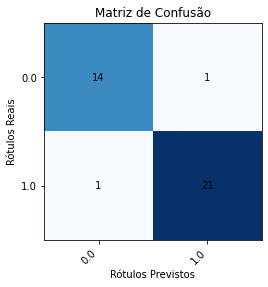

In [16]:
y_predict_mdeep = train_test_mdeep(args={"outcome_type": "binary", "batch_size": 32, "num_epochs": 500, "learning_rate": 1e-4, "dropout_rate": 0.5, "window_size": 128, "kernel_size": (32, 32), "strides": (64, 2), "X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test })

precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_mdeep)
print(f"Epoch: {epoch+1}/{epochs}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_matrix_mdeep = confusion_matrix(y_test, y_predict_mdeep)
plot_Confusion_Matrix(confusion_matrix_mdeep)

Precision: 0.9545
Recall: 0.9545
Accuracy: 0.9459
F1-Score: 0.9545
F2-Measure: 0.9545
--------------------
indice: [10, 12]


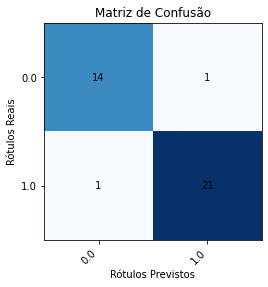

In [17]:
precision, recall, accuracy, f1, f2 = calculate_metrics(true_ouputs.tolist(), ouputs_squeezed.tolist())
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_ouputs.tolist(), ouputs_squeezed.tolist())) if true != pred]
print(f"indice: {misclassified_indices}")

confusion_Micronet = confusion_matrix(y_test, ouputs_squeezed.tolist())
plot_Confusion_Matrix(confusion_Micronet)

Epoch: 10/10
Precision: 0.9474
Recall: 0.8182
Accuracy: 0.8649
F1-Score: 0.8780
F2-Measure: 0.8411
--------------------


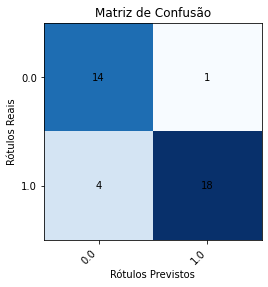

In [18]:
    mlp_pred, clp = Perceptron_Model(X_train, y_train, X_test)
    precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, mlp_pred)


    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Measure: {f2:.4f}")
    print("--------------------")

    confusion_mat_mlp = confusion_matrix(y_test, mlp_pred)
    plot_Confusion_Matrix(confusion_mat_mlp)

Epoch: 10/10
Precision: 1.0000
Recall: 0.8182
Accuracy: 0.8919
F1-Score: 0.9000
F2-Measure: 0.8491
--------------------


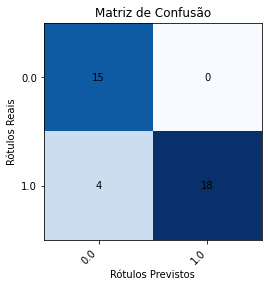

In [19]:
y_predict_dt, clf = Decision_Tree_Model(X_train, y_train, X_test)
precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_dt)


print(f"Epoch: {epoch+1}/{epochs}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_mat_dt = confusion_matrix(y_test, y_predict_dt)
plot_Confusion_Matrix(confusion_mat_dt)

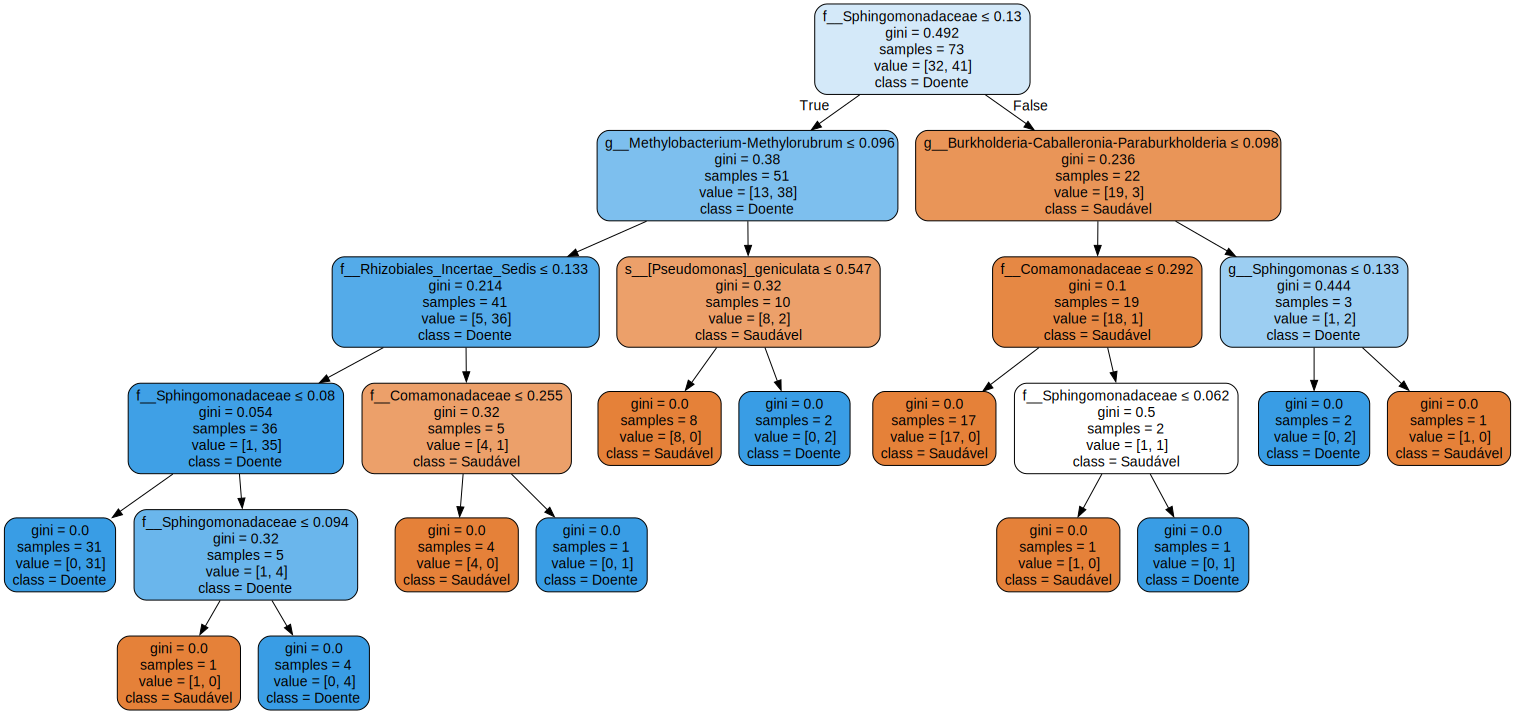

In [20]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(clf, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names= ["Doente" if value == 1.0 else "Saudável" for value in clf.classes_],  
                      filled=True, rounded=True,  
                      special_characters=True)

graph = graphviz.Source(dot_data)
a = pydotplus.graph_from_dot_data(dot_data)
a.write_png('decision_tree.png')
graph 

Precision: 1.0000
Recall: 0.8182
Accuracy: 0.8919
F1-Score: 0.9000
F2-Measure: 0.8491
--------------------


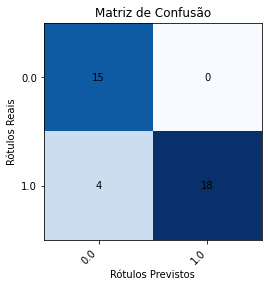

In [21]:
y_predict_rf, clr = Random_Forest_Model(X_train, y_train, X_test)
precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_rf)



print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_mat_rf = confusion_matrix(y_test, y_predict_rf)
plot_Confusion_Matrix(confusion_mat_rf)

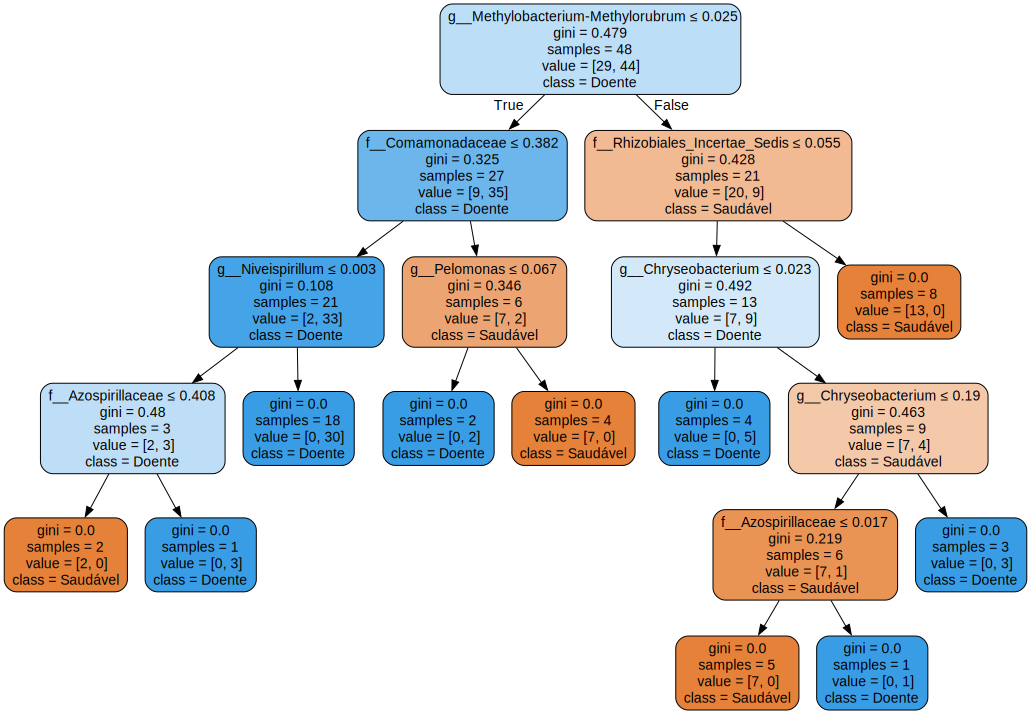

In [22]:


tree = clr.estimators_[0]


dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=["Doente" if value == 1.0 else "Saudável" for value in clr.classes_],
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)
a = pydotplus.graph_from_dot_data(dot_data)
a.write_png('random_tree.png')
graph 

Epoch: 10/10
Precision: 1.0000
Recall: 0.8182
Accuracy: 0.8919
F1-Score: 0.9000
F2-Measure: 0.8491
--------------------


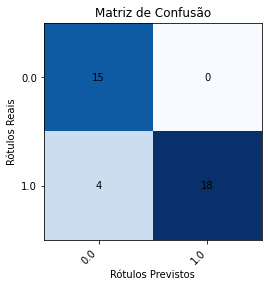

In [23]:
y_predict_svm, cls = SVM_Model(X_train, y_train, X_test)
precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_svm)


print(f"Epoch: {epoch+1}/{epochs}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_mat_svm = confusion_matrix(y_test, y_predict_svm)
plot_Confusion_Matrix(confusion_mat_svm)

In [24]:
confusion_matrix_mdeep

array([[14,  1],
       [ 1, 21]], dtype=int64)

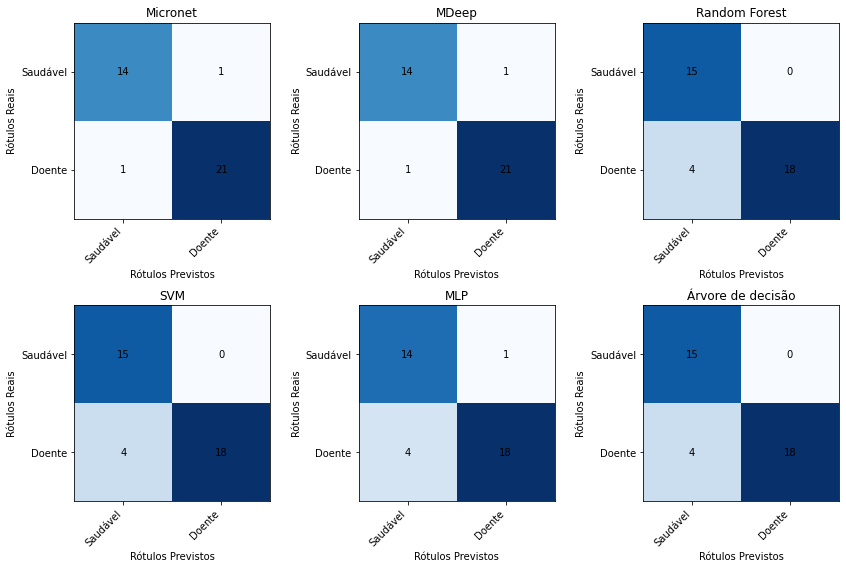

In [25]:

plot_Confusion_Matrices([("Micronet", confusion_Micronet),
                         ("MDeep",confusion_matrix_mdeep),
                         ("Random Forest",confusion_mat_rf),
                         ("SVM",confusion_mat_svm),
                         ("MLP", confusion_mat_mlp),
                        ("Árvore de decisão",confusion_mat_dt),])


In [26]:
def plot_ROC(y_true, y_preds):
    plt.figure(figsize=(8, 6))

    blues = ['#1f77b4', '#98df8a', 'orange', '#2ca02c', '#8c564b', 'red']


    colors = blues
    random_color = 'darkred'

    for i, (name, y_pred) in enumerate(y_preds):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        if name == "SVM":
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})', linestyle='--',  color=colors[i])
        else:
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})', linestyle='-',  color=colors[i])

    plt.plot([0, 1], [0, 1], color=random_color, lw=2, linestyle='--', label='Aleatório')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva Característica de Operação do Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [27]:
mlp_pred.shape

(37,)

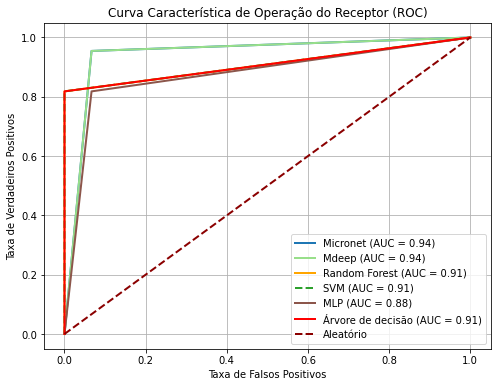

In [28]:
plot_ROC(y_test.values, [("Micronet", ouputs_squeezed.tolist()),
                         ("Mdeep", y_predict_mdeep),
                         ("Random Forest", y_predict_rf),
                         ("SVM", y_predict_svm),
                         ("MLP", mlp_pred),
                         ("Árvore de decisão", y_predict_dt)])

In [29]:

def microNet_predict(input_data):
    input_tensor = torch.FloatTensor(input_data)
    return microNet(input_tensor).detach().numpy()

In [30]:

explainer = shap.KernelExplainer(microNet_predict, X_train)
shap_values = explainer.shap_values(X_train)
rf_explainer = shap.TreeExplainer(clr)
rf_shap_values = rf_explainer.shap_values(X_train)
dt_explainer = shap.TreeExplainer(clf)
dt_shap_values = dt_explainer.shap_values(X_train)
svm_explainer = shap.KernelExplainer(cls.predict, X_train)
svm_shap_values = svm_explainer.shap_values(X_train)



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

In [31]:
explainer_mdeep = shap.KernelExplainer(model_predict_mdeep, X_train)
shap_values_mdeep = explainer_mdeep.shap_values(X_train)



  0%|          | 0/73 [00:00<?, ?it/s]

In [32]:

mlp_explainer = shap.KernelExplainer(clp.predict, X_train)
mlp_shap_values = mlp_explainer.shap_values(X_train)

  0%|          | 0/73 [00:00<?, ?it/s]

In [33]:
shap.initjs()

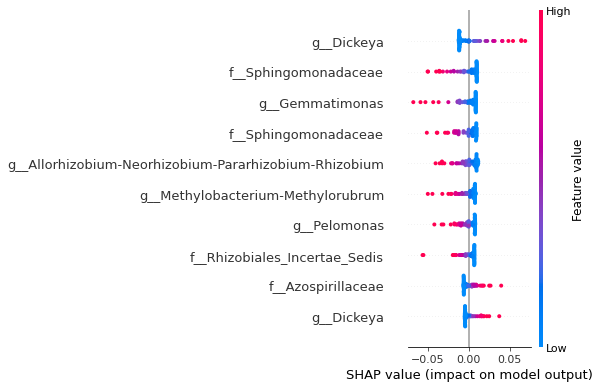

<Figure size 1296x1080 with 0 Axes>

In [34]:
shap.summary_plot(shap_values[0], X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

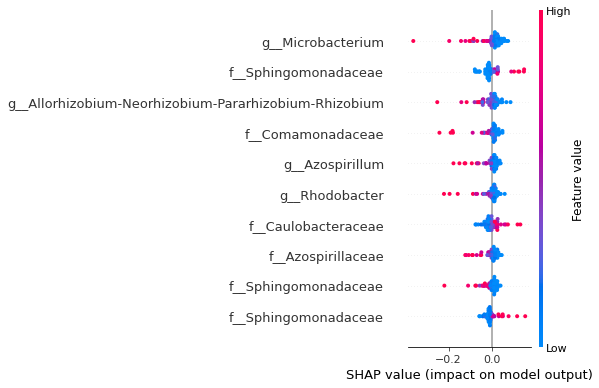

<Figure size 1296x1080 with 0 Axes>

In [35]:

shap.summary_plot(shap_values_mdeep, X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

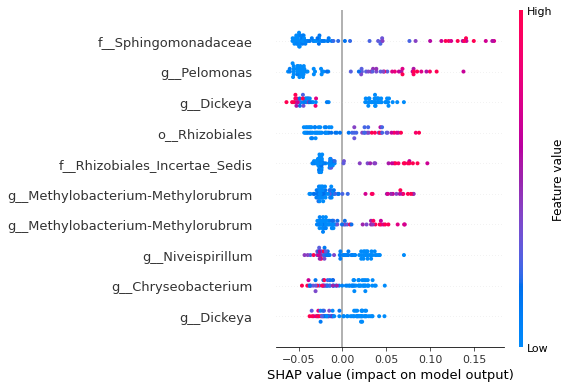

<Figure size 1296x1080 with 0 Axes>

In [36]:
shap.summary_plot(rf_shap_values[0], X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

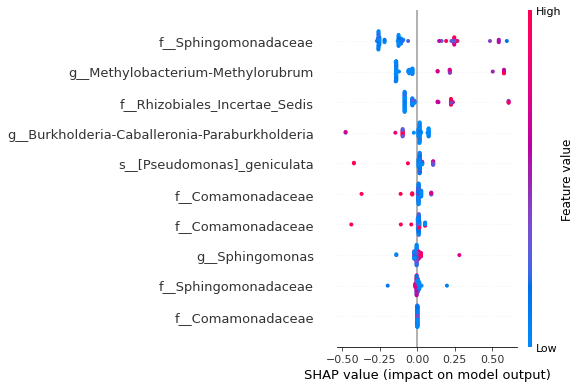

<Figure size 1296x1080 with 0 Axes>

In [37]:
shap.summary_plot(dt_shap_values[0], X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

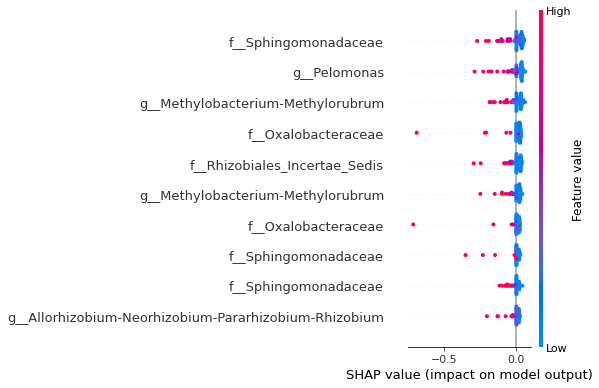

<Figure size 1296x1080 with 0 Axes>

In [38]:
shap.summary_plot(svm_shap_values, X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

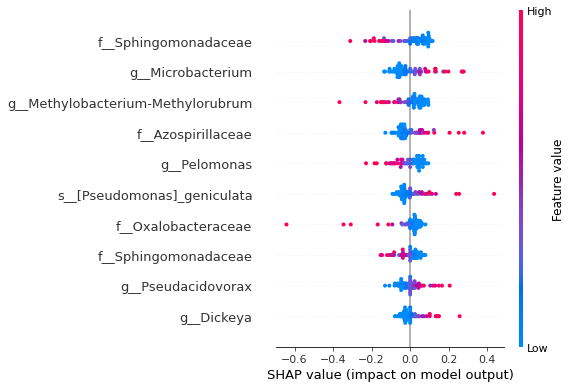

<Figure size 1296x1080 with 0 Axes>

In [39]:
shap.summary_plot(mlp_shap_values, X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()